In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import joblib

In [2]:
# Load dataset
df = pd.read_csv('health_emergencies.csv')
df.columns = [c.strip() for c in df.columns]

In [3]:
df.head()

Date  Year   Time Day_of_Week                 Barangay   Latitude  \
0  23/11/2025  2025  13:14    Thursday         San Mateo (Imok)  14.089903   
1  07/05/2022  2022  13:58     Tuesday                      V-C  14.106827   
2  30/09/2024  2024  15:47      Monday                      V-B  14.080581   
3  07/10/2021  2021  12:03      Sunday             San Gregorio  14.031415   
4  11/10/2025  2025  20:19      Sunday  San Antonio 1 (Balanga)  14.012716   

    Longitude Weather        Health_Type     Health_Cause Severity  \
0  121.333461   Foggy  Allergic Reaction        Infection     High   
1  121.282542  Stormy               Fall  Chronic Illness      Low   
2  121.274854   Rainy               Burn         Accident   Medium   
3  121.299749   Sunny               Burn            Other   Medium   
4  121.348980   Sunny  Allergic Reaction          Allergy     High   

   Patient_Count  Response_Time  Treatment_Time  
0              3             12              43  
1              3             12              39  
2              2             20              28  
3              1              9              13  
4              1             14              27

In [4]:
df.shape

(1500, 14)

In [5]:
df.columns

Index(['Date', 'Year', 'Time', 'Day_of_Week', 'Barangay', 'Latitude',
       'Longitude', 'Weather', 'Health_Type', 'Health_Cause', 'Severity',
       'Patient_Count', 'Response_Time', 'Treatment_Time'],
      dtype='object')

In [6]:
# Handle missing values
df = df.dropna(subset=['Year', 'Barangay', 'Health_Type', 'Health_Cause', 'Severity'])

In [7]:
# Define features and target
X = df[['Year', 'Barangay', 'Health_Type', 'Health_Cause']]
y = df['Severity'].apply(lambda x: 1 if x in ['Medium', 'High'] else 0)  # 1 for severe, 0 for low

In [8]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Year']),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['Barangay', 'Health_Type', 'Health_Cause'])
    ]
)

In [9]:
# Random Forest pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42))
])

In [10]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [11]:
# Train model
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Year']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Barangay', 'Health_Type',
                                                   'Health_Cause'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, random_state=42))])

In [12]:
# Make predictions
y_pred = pipe.predict(X_test)

In [13]:
print("=== Random Forest - Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

=== Random Forest - Classification Report ===
              precision    recall  f1-score   support

           0     1.0000    0.0144    0.0284       139
           1     0.6942    1.0000    0.8195       311

    accuracy                         0.6956       450
   macro avg     0.8471    0.5072    0.4239       450
weighted avg     0.7887    0.6956    0.5751       450



=== Random Forest - Confusion Matrix ===
[[  2 137]
 [  0 311]]


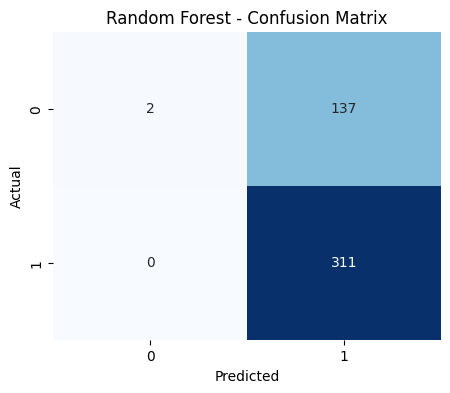

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("=== Random Forest - Confusion Matrix ===")
print(cm)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

=== Random Forest - ROC AUC: 0.5344 ===


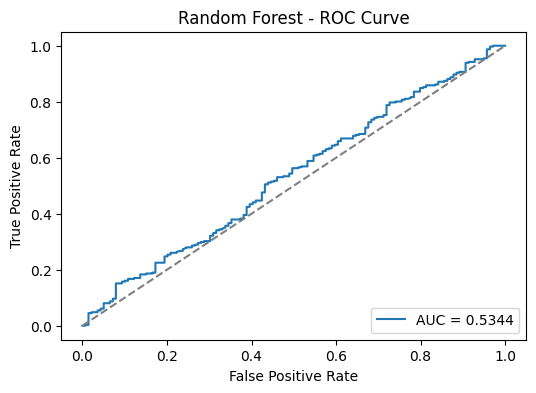

In [15]:
# ROC Curve
y_proba = pipe.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
print(f"=== Random Forest - ROC AUC: {roc_auc:.4f} ===")
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest - ROC Curve")
plt.legend(loc='lower right')
plt.show()

In [16]:
# Save model
joblib.dump(pipe, "health_predictor_rf.pkl")
print("Saved model to health_predictor_rf.pkl")

Saved model to health_predictor_rf.pkl
